<a href="https://colab.research.google.com/github/ValentinaTosic/RI-project/blob/main/my_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [12]:
import numpy as np
import matplotlib.pyplot as plt

In [13]:
import sys
import time
import copy
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision
import torchvision.transforms as transforms
from torchvision import models
from pathlib import Path

In [14]:
if torch.cuda.is_available():
    dev = "cuda:0"
else:
    dev = "cpu"
device = torch.device(dev)

In [15]:
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [16]:
!git clone https://github.com/ValentinaTosic/RI-project.git


fatal: destination path 'RI-project' already exists and is not an empty directory.


In [17]:
%cd RI-project/input/100-bird-species/

/content/RI-project/input/100-bird-species


In [18]:
train_path = "./train/"
test_path  = "./test/"
val_path = "./valid/"

In [19]:
crop_size = 224
train_transform = transforms.Compose(
   [
    transforms.RandomRotation(10),
    transforms.RandomResizedCrop(crop_size, scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Resize((80,80)),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ]
)

test_transform = transforms.Compose([
    transforms.Resize(230),
    transforms.CenterCrop(crop_size),
    transforms.ToTensor(),
    transforms.Resize((80,80)),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])


train_set = torchvision.datasets.ImageFolder(root=train_path, transform=train_transform)
trainloader = torch.utils.data.DataLoader(train_set, batch_size=64, shuffle=True)

test_set = torchvision.datasets.ImageFolder(root=test_path, transform=test_transform)
testloader = torch.utils.data.DataLoader(test_set, batch_size=64)

val_set = torchvision.datasets.ImageFolder(root=val_path, transform=test_transform)
valloader = torch.utils.data.DataLoader(val_set, batch_size=64)

dataloaders = {
    "train": trainloader,
    "test": testloader
}
datasizes = {
    "train": len(train_set),
    "test": len(test_set)
}
CLASSES = list(train_set.class_to_idx.keys())

In [20]:
len(train_set), len(val_set), len(test_set)

(15759, 500, 500)

In [21]:
birds = train_set.classes
birds, len(birds)

(['ABBOTTS BABBLER',
  'ABBOTTS BOOBY',
  'ABYSSINIAN GROUND HORNBILL',
  'AFRICAN CROWNED CRANE',
  'AFRICAN EMERALD CUCKOO',
  'AFRICAN FIREFINCH',
  'AFRICAN OYSTER CATCHER',
  'AFRICAN PIED HORNBILL',
  'AFRICAN PYGMY GOOSE',
  'ALBATROSS',
  'ALBERTS TOWHEE',
  'ALEXANDRINE PARAKEET',
  'ALPINE CHOUGH',
  'ALTAMIRA YELLOWTHROAT',
  'AMERICAN AVOCET',
  'AMERICAN BITTERN',
  'AMERICAN COOT',
  'AMERICAN DIPPER',
  'AMERICAN FLAMINGO',
  'AMERICAN GOLDFINCH',
  'AMERICAN KESTREL',
  'AMERICAN PIPIT',
  'AMERICAN REDSTART',
  'AMERICAN ROBIN',
  'AMERICAN WIGEON',
  'AMETHYST WOODSTAR',
  'ANDEAN GOOSE',
  'ANDEAN LAPWING',
  'ANDEAN SISKIN',
  'ANHINGA',
  'ANIANIAU',
  'ANNAS HUMMINGBIRD',
  'ANTBIRD',
  'ANTILLEAN EUPHONIA',
  'APAPANE',
  'APOSTLEBIRD',
  'ARARIPE MANAKIN',
  'ASHY STORM PETREL',
  'ASHY THRUSHBIRD',
  'ASIAN CRESTED IBIS',
  'ASIAN DOLLARD BIRD',
  'ASIAN GREEN BEE EATER',
  'ASIAN OPENBILL STORK',
  'AUCKLAND SHAQ',
  'AUSTRAL CANASTERO',
  'AUSTRALASIAN FIGBIR

In [22]:
feature, target = next(iter(trainloader)) #vraca prvi u trainloaderu, iter sato sto nije iterator pa ga kastujemo, nest da uzmemo prvi element, ako bi ponovo pozvali uzeli bi drugi
feature.shape

torch.Size([64, 3, 80, 80])

In [23]:
def imshow(img, size=(10, 10)):
    img = img / 2 + 0.5
    npimg = img.numpy()
    if size:
        plt.figure(figsize=size)

    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.title("One mini batch")
    plt.axis("off")
    plt.pause(0.001)

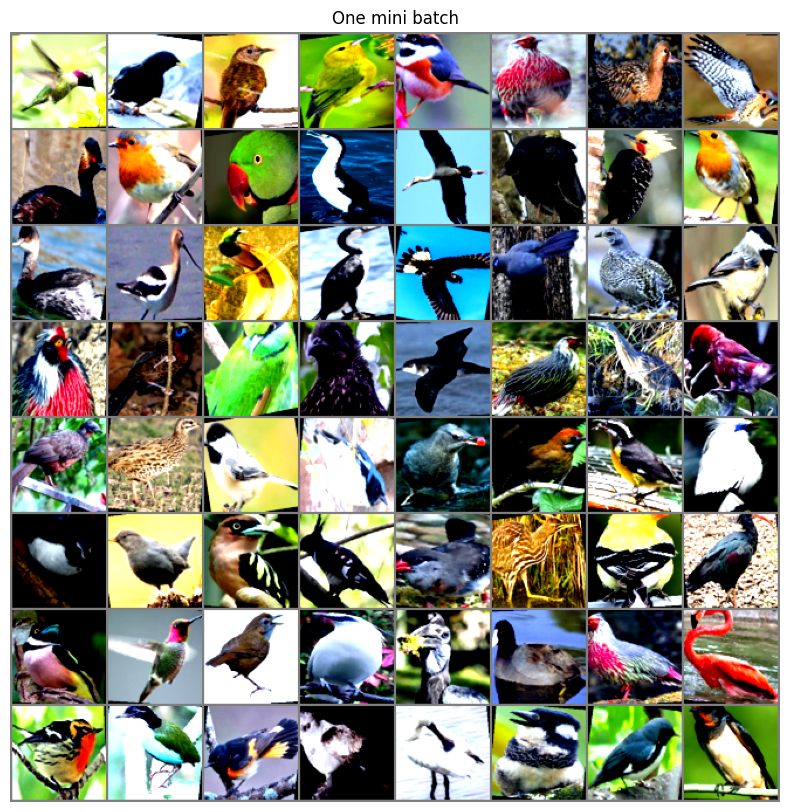

In [24]:
dataiter = iter(trainloader)
images, labels = next(dataiter)

imshow(torchvision.utils.make_grid(images))

In [25]:
class ConvNet(nn.Module):

    def __init__(self):
        super().__init__()

        self.conv1 = nn.Conv2d(3, 32, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(32, 64, 5)
        self.flatten = nn.Flatten(start_dim=1)
        self.fc1 = nn.Linear(18496, 1600)
        self.fc2 = nn.Linear(1600, 512)
        self.fc3 = nn.Linear(512, 100)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.flatten(x)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

model = ConvNet()
model.to(device)

ConvNet(
  (conv1): Conv2d(3, 32, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=18496, out_features=1600, bias=True)
  (fc2): Linear(in_features=1600, out_features=512, bias=True)
  (fc3): Linear(in_features=512, out_features=100, bias=True)
)

In [26]:
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

In [27]:
def train_loop(dataloader, model, loss_fn, optimizer, device):
    model.train()
    for X, y in dataloader:
        X, y = X.to(device), y.to(device)
        preds = model(X)
        loss = loss_fn(preds, y)

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

In [28]:
def test_loop(dataloader, model, loss_fn, device):
    model.eval()
    with torch.no_grad():
        total_loss = 0
        num_same = 0
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            outputs = model(X)
            loss = loss_fn(outputs, y)
            total_loss += loss.item()

            if len(outputs.shape) == 1:
                preds = outputs > 0
                num_same += sum(preds == y).item()
            else: # accuracy - vise klasa
                _, indices = torch.max(outputs, 1)
                num_same += sum(indices == y).item()
        print(f'Average loss: {total_loss / len(dataloader.dataset)}')
        print(f'Accuracy: {num_same / len(dataloader.dataset)}')

In [29]:
for epoch in range(8):
     train_loop(trainloader, model, loss_fn, optimizer, device)
     test_loop(testloader, model, loss_fn, device)

Average loss: 0.05334048080444336
Accuracy: 0.172
Average loss: 0.03848352670669555
Accuracy: 0.39
Average loss: 0.030879107713699342
Accuracy: 0.486
Average loss: 0.023571799874305726
Accuracy: 0.598
Average loss: 0.02034182333946228
Accuracy: 0.636
Average loss: 0.019810172200202942
Accuracy: 0.646
Average loss: 0.015278265953063965
Accuracy: 0.744
Average loss: 0.014201091527938843
Accuracy: 0.752


In [30]:
def imshowaxis(ax, img, orig, pred):
    img = img / 2 + 0.5
    npimg = img.numpy()
    ax.imshow(np.transpose(npimg, (1, 2, 0)))
    if orig != pred:
        ax.set_title(orig + "\n" + pred, color="red")
    else:
        ax.set_title(orig + "\n" + pred)
    ax.axis("off")


def vis_model(model, num_images=25):
    was_training = model.training
    model.eval()
    images_so_far = 0
    figure, ax = plt.subplots(5, 5, figsize=(20, 20))


    with torch.no_grad():
        for i , (inputs, labels) in enumerate(dataloaders["test"]):
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for i in range(5):
                for j in range(5):
                    if images_so_far < num_images:
                        imshowaxis(ax[i][j], inputs.cpu().data[images_so_far], CLASSES[labels[images_so_far]], CLASSES[preds[images_so_far]])
                    else:
                        model.train(mode=was_training)
                        return
                    images_so_far += 1
        model.train(mode=was_training)

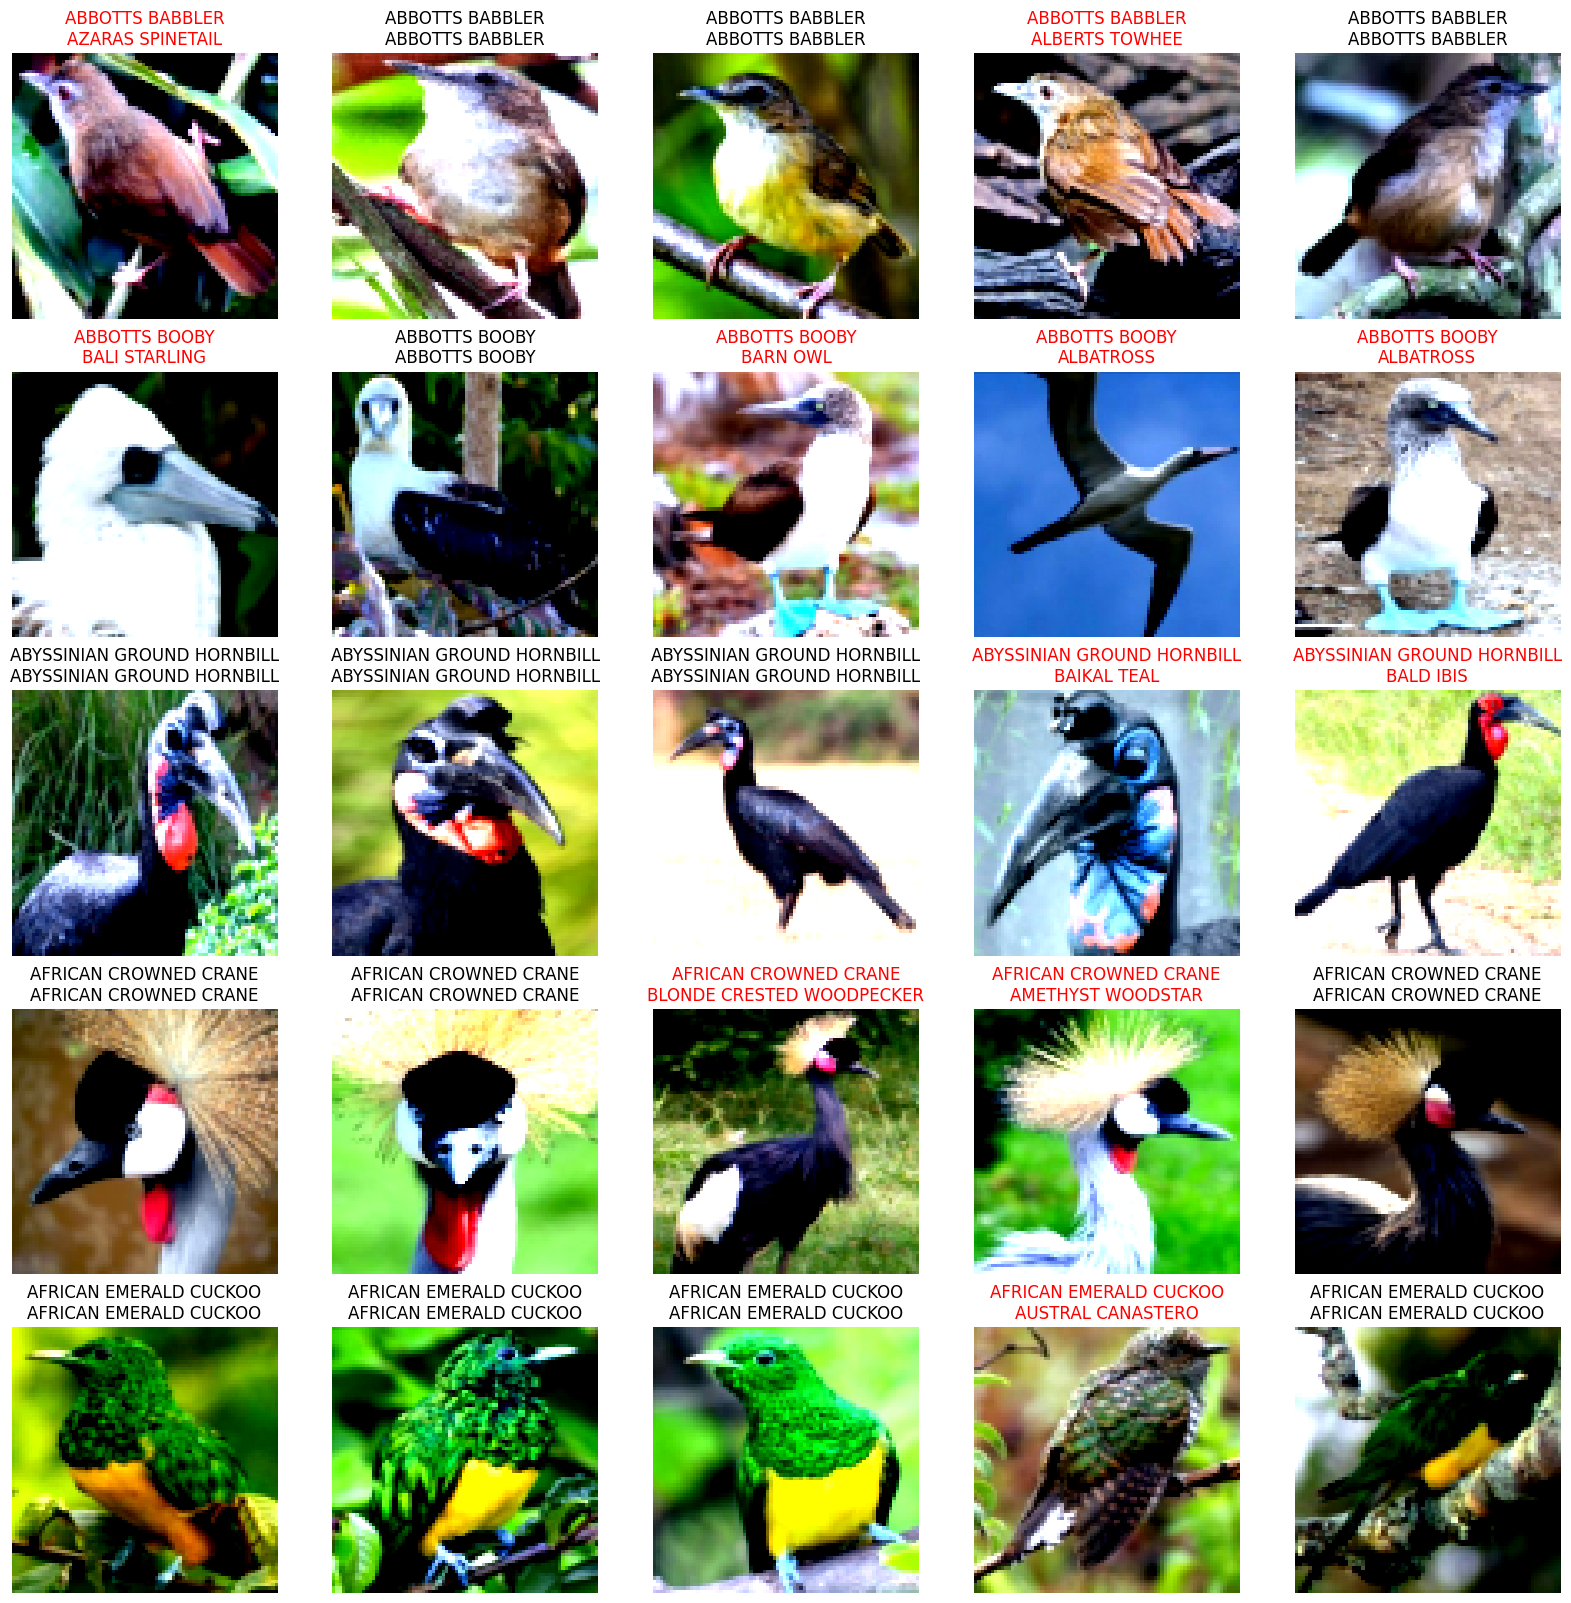

In [31]:
vis_model(model)